In [1]:
import tensorflow as tf
import keras
import os
import shutil
import cv2
import numpy as np

import glob as glob
import matplotlib.pyplot as plt
from keras.models import load_model
import segmentation_models_3D as sm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

focal_loss = sm.losses.CategoricalFocalLoss()


Segmentation Models: using `tf.keras` framework.


# Evaluating on Test Data

In [84]:
test_dir = "Evaluation/Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=16,
    image_size=(256, 256),
    seed=123,
    shuffle=False,
    interpolation='area'
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


Found 394 files belonging to 4 classes.


In [3]:
vgg19 = load_model("model_checkpoints/vgg19_cc_loss.hdf5")
densenet121 = load_model("model_checkpoints/densenet121_focal_loss.hdf5", custom_objects={'focal_loss': focal_loss})
mobilenetv2 = load_model("model_checkpoints/mobilenetv2_focal_loss.hdf5",  custom_objects={'focal_loss': focal_loss})



In [93]:
pip install tensorflow_datasets

     ---------------------------------------- 5.4/5.4 MB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 4.4 MB/s eta 0:00:00
     ---------------------------------------- 97.9/97.9 kB 5.8 MB/s eta 0:00:00
     -------------------------------------- 101.3/101.3 kB 6.1 MB/s eta 0:00:00
     -------------------------------------- 135.8/135.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 430.4/430.4 kB 8.9 MB/s eta 0:00:00
     ------------------------------------- 227.6/227.6 kB 14.5 MB/s eta 0:00:00
  Using cached protobuf-3.20.3-cp310-cp310-win_amd64.whl (904 kB)
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21548 sha256=3189152dbc02891d9412e57273fb5d7428fa8264f19c20aa896ca5cb38343176
  Stored in directory: c:\users\anubhav\appdata\local\pip\cache\wheels\54\4e\28\3ed0e1c8a752867445bab994d2340724928aa3ab059c57

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Anubhav\\anaconda3\\envs\\tf\\Lib\\site-packages\\google\\~8otobuf\\internal\\_api_implementation.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [95]:
predictions = vgg19.predict(test_ds)


25/25 [==============================] - 3s 119ms/step


In [5]:
predictions[0]

array([9.9848455e-01, 3.6710370e-04, 2.5276607e-04, 8.9568121e-04],
      dtype=float32)

# Create an Ensemble model

In [6]:
models = [vgg19, densenet121, mobilenetv2]


In [7]:
y_test =  np.array([])
for x, y in test_ds:
  print(y.shape)
  y_test = np.concatenate([y_test, y.numpy()])

(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(10,)


In [8]:
y_test.shape
y_test[0]

0.0

In [22]:
preds = [model.predict(test_ds) for model in models]
preds = np.array(preds)
weights = [0.4, 0.3, 0.3]


25/25 [==============================] - 1s 30ms/step


In [23]:
preds.shape

(3, 394, 4)

In [12]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


# Weighted Ensemble approach

In [25]:
from sklearn.metrics import accuracy_score

weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(y_test, weighted_ensemble_prediction)

In [26]:
# Weighted accuracy from randomly initialized weights
print(weighted_accuracy)

0.9873096446700508


In [27]:
weighted_preds.shape

(394, 4)

In [28]:
preds

array([[[9.9848455e-01, 3.6710370e-04, 2.5276607e-04, 8.9568121e-04],
        [9.9999988e-01, 2.3715780e-08, 1.3956732e-09, 5.8369892e-08],
        [9.9988854e-01, 2.4827932e-05, 1.3871686e-06, 8.5312531e-05],
        ...,
        [3.3930484e-03, 7.9039726e-03, 4.9192454e-06, 9.8869801e-01],
        [1.8160634e-07, 1.3162002e-03, 1.2363295e-05, 9.9867129e-01],
        [9.8399926e-07, 9.0859030e-05, 6.3902873e-05, 9.9984419e-01]],

       [[9.9998093e-01, 1.8725044e-05, 3.2149632e-08, 3.4989625e-07],
        [1.0000000e+00, 8.3984052e-12, 3.6387733e-12, 6.6359315e-13],
        [1.0000000e+00, 9.4393720e-09, 1.6023181e-10, 1.5393098e-10],
        ...,
        [9.2031667e-07, 1.7687822e-06, 8.4420016e-08, 9.9999714e-01],
        [5.0181126e-09, 9.8878591e-06, 3.0816543e-06, 9.9998701e-01],
        [8.8024846e-13, 4.3709696e-07, 2.2521784e-09, 9.9999952e-01]],

       [[9.8828286e-01, 6.8919770e-03, 1.2008512e-03, 3.6243275e-03],
        [9.9965417e-01, 3.0602398e-04, 2.6966395e-06, 3.7103

In [29]:
prediction1 = vgg19.predict(test_ds)
prediction1 = prediction1.argmax(axis=-1)

prediction2 = densenet121.predict(test_ds)
prediction2 = prediction2.argmax(axis=-1)

prediction3 = mobilenetv2.predict(test_ds)
prediction3 = prediction3.argmax(axis=-1)

25/25 [==============================] - 1s 30ms/step


In [30]:
prediction1.shape

(394,)

In [31]:
accuracy1 = accuracy_score(y_test, prediction1)
accuracy2 = accuracy_score(y_test, prediction2)
accuracy3 = accuracy_score(y_test, prediction3)

In [32]:
print(accuracy1)
print(accuracy2)
print(accuracy3)

0.9847715736040609
0.9873096446700508
0.9746192893401016


# Weighted Ensemble using Grid Search

In [66]:
import pandas as pd
df = []

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(y_test, wted_ensemble_pred)
            df.append({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'acc':weighted_accuracy*100, 'preds':wted_ensemble_pred})

In [67]:
df = pd.DataFrame(df)

In [68]:
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0], " w2=", max_acc_row[1], " and w3=", max_acc_row[2])
print(max_acc_row[4])         


Max accuracy of  98.98477157360406  obained with w1= 0.1  w2= 0.1  and w3= 0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [69]:
preds = max_acc_row[4]

In [57]:
df.head(15)

,wt1,wt2,wt3,acc
0,0.0,0.0,0.0,22.842640
1,0.0,0.0,0.1,97.461929
2,0.0,0.0,0.2,97.461929
3,0.0,0.0,0.3,97.461929
4,0.0,0.0,0.4,97.461929
5,0.0,0.1,0.0,98.730964
6,0.0,0.1,0.1,98.730964
7,0.0,0.1,0.2,98.223350
8,0.0,0.1,0.3,98.477157
9,0.0,0.1,0.4,98.477157


In [35]:
max_acc= np.array(max_acc)
max_acc.shape
prediction = np.argmax(max_acc)
print(max_acc.shape)

(125,)


In [36]:
print(max_acc[prediction])

# Test accuracy improved by 0.2% from the best model

0.9898477157360406


In [99]:
pip install seaborn

     -------------------------------------- 293.3/293.3 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [102]:
testing_datagen = ImageDataGenerator(rescale=1./ 255)

testing_generator = testing_datagen.flow_from_directory(
test_dir,
target_size=(256,256),
batch_size=16,
shuffle=False,
class_mode='categorical')

target_names = []
for key in testing_generator.class_indices:
    target_names.append(key)

Found 394 images belonging to 4 classes.


[Text(0, 0.5, 'glioma'),
 Text(0, 1.5, 'meningioma'),
 Text(0, 2.5, 'notumor'),
 Text(0, 3.5, 'pituitary')]

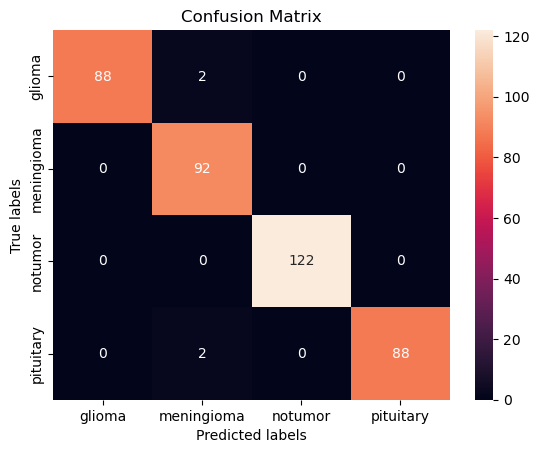

In [104]:
## Confusion Matrix

from sklearn.metrics import confusion_matrix
from sklearn import metrics

cm = confusion_matrix(y_test, preds)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [True, True])
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names)

In [105]:
#Print Classification Report
print('Classification Report')
print(classification_report(testing_generator.classes, preds, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99        90
  meningioma       0.96      1.00      0.98        92
     notumor       1.00      1.00      1.00       122
   pituitary       1.00      0.98      0.99        90

    accuracy                           0.99       394
   macro avg       0.99      0.99      0.99       394
weighted avg       0.99      0.99      0.99       394

